<a href="https://colab.research.google.com/github/Daniel8B/Plovdiv-Real-Estate-Price-Prediction/blob/main/Plovdiv_Real_Estate_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and Import dependencies

In [444]:
!pip install optuna streamlit

In [445]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import streamlit as st

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold

from scipy.stats import zscore

import xgboost as xg


## Data cleaning and preparation

In [446]:
url = "https://raw.githubusercontent.com/Daniel8B/Plovdiv-Real-Estate-Price-Prediction/main/estate_df_upload.csv"
df = pd.read_csv(url)

In [447]:
df.head()

,Unnamed: 0,title,district,Цена,Вид на имота,Квадратура,Вид строителство,Година на строителство,Номер на етажа,Етаж,Степен на завършеност
0,0,ЕКСКЛУЗИВНО!! С АКТ 16!! Двустаен апартамент Х...,Христо Смирненски,104 999 EUR (1 312.49 EUR/кв.м),Двустаен апартамент в Пловдив,80 кв.м,Тухла,2021 г.,NaN,Непоследен,NaN
1,1,Двустаен апартамент 67 кв.м Панел 1995 г. 5 ет...,Изгрев,61 500 EUR (917.91 EUR/кв.м),Двустаен апартамент в Пловдив,67 кв.м,Панел,1995 г.,5 етаж,Непоследен,NaN
2,2,Без комисиона! С АКТ 14! Тристаен апартамент Х...,Христо Смирненски,89 760 EUR (880 EUR/кв.м),Тристаен апартамент в Пловдив,102 кв.м,Тухла,2023 г.,NaN,Непоследен,В строеж
3,3,Три отделни стаи Панаира,Кършияка,101 000 EUR (1 216.87 EUR/кв.м),Тристаен апартамент в Пловдив,83 кв.м,Панел,1980 г.,NaN,Непоследен,NaN
4,4,ТОП ОФЕРТА! Едностаен апартамент Остромила,Остромила,29 520 EUR (720 EUR/кв.м),Едностаен апартамент в Пловдив,41 кв.м,Тухла,2024 г.,NaN,Непоследен,В строеж


In [448]:
#Drop the index and "title" columns
df.drop(['Unnamed: 0', 'title'], axis=1, inplace=True)

In [449]:
# Rename the columns to English

new_cols = {"Цена":"price", "Вид на имота": "apartment type",
            "Квадратура": "square meters",
            "Вид строителство": "construction type",
            "Година на строителство": "construction year",
            "Номер на етажа": "floor number",
            "Етаж": "floor", "Степен на завършеност": "level of completion"}

df.rename(columns=new_cols, inplace=True)

In [450]:
# Remove all white spaces from the values in each column
for col in df.columns:
  df[col] = df[col].str.strip()

In [451]:
df.shape

(16163, 9)

In [452]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16163 entries, 0 to 16162
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   district             16163 non-null  object
 1   price                16004 non-null  object
 2   apartment type       16163 non-null  object
 3   square meters        16163 non-null  object
 4   construction type    16163 non-null  object
 5   construction year    14916 non-null  object
 6   floor number         13285 non-null  object
 7   floor                15436 non-null  object
 8   level of completion  6090 non-null   object
dtypes: object(9)
memory usage: 1.1+ MB


In [453]:
print(f'Percentage of missing values in the`construction year`column: {(df["construction year"].isna().sum()/len(df["construction year"])*100):.2f}%')

Percentage of missing values in the`construction year`column: 7.72%


Drop the missing values from `construction year`.

Given that the year of construction is a major factor in determining price and there is no straightforward way to infer the year of a building by other data values, we will drop them.

Also, the missing values are 7.72% of all entries so we can afford to drop them.
<hr>

Drop the missing values in `price`.

In [454]:
df.dropna(subset=["construction year", "price"],inplace=True)

In [455]:
df.shape

(14771, 9)

In [456]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14771 entries, 0 to 16160
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   district             14771 non-null  object
 1   price                14771 non-null  object
 2   apartment type       14771 non-null  object
 3   square meters        14771 non-null  object
 4   construction type    14771 non-null  object
 5   construction year    14771 non-null  object
 6   floor number         11929 non-null  object
 7   floor                14407 non-null  object
 8   level of completion  5711 non-null   object
dtypes: object(9)
memory usage: 1.1+ MB


## Prepare `floor number`, `floor` and `level of completion` columns

In [457]:
df["floor number"].value_counts()

2 етаж      2317
3 етаж      2186
4 етаж      1783
5 етаж      1658
1 етаж      1206
6 етаж      1019
7 етаж       588
8 етаж       450
9 етаж       283
10 етаж      135
11 етаж      111
12 етаж       58
14 етаж       37
13 етаж       31
15 етаж       27
16 етаж       19
17 етаж        9
18 етаж        4
19 етаж        2
72 етаж        1
64 етаж        1
2.3 етаж       1
68 етаж        1
22 етаж        1
69 етаж        1
Name: floor number, dtype: int64

In [458]:
def floor_number_rework(df):

  # Find the median floor number
  median_floor = df[~df["floor number"].isna()]["floor number"].str.split(" ").str[0].median()

  # Create a variable with the new floor numbers
  floor_numbers = df["floor number"].str.split(" ").str[0].fillna(median_floor)

  # Edit the floor values
  df.loc[floor_numbers.index, "floor number"] = floor_numbers.values

  # Change the only float value to the closest int
  df.loc[df[df["floor number"] == "2.3"]["floor number"].index, "floor number"] = 2

  # Since we don't have floats anymore, we can change the column type to int
  df["floor number"] = df["floor number"].astype(int)

  # Set all floors above 20 to the median value
  df.loc[df["floor number"] > 20,"floor number"] = 4

  return df

In [459]:
floor_number_rework(df)

,district,price,apartment type,square meters,construction type,construction year,floor number,floor,level of completion
0,Христо Смирненски,104 999 EUR (1 312.49 EUR/кв.м),Двустаен апартамент в Пловдив,80 кв.м,Тухла,2021 г.,4,Непоследен,NaN
1,Изгрев,61 500 EUR (917.91 EUR/кв.м),Двустаен апартамент в Пловдив,67 кв.м,Панел,1995 г.,5,Непоследен,NaN
2,Христо Смирненски,89 760 EUR (880 EUR/кв.м),Тристаен апартамент в Пловдив,102 кв.м,Тухла,2023 г.,4,Непоследен,В строеж
3,Кършияка,101 000 EUR (1 216.87 EUR/кв.м),Тристаен апартамент в Пловдив,83 кв.м,Панел,1980 г.,4,Непоследен,NaN
4,Остромила,29 520 EUR (720 EUR/кв.м),Едностаен апартамент в Пловдив,41 кв.м,Тухла,2024 г.,4,Непоследен,В строеж
...,...,...,...,...,...,...,...,...,...
16154,Кършияка,212 865 EUR (1 663 EUR/кв.м),Тристаен апартамент в Пловдив,128 кв.м,Тухла,2022 г.,3,NaN,В строеж
16155,Кършияка,102 062 EUR (1 673.15 EUR/кв.м),Едностаен апартамент в Пловдив,61 кв.м,Тухла,2022 г.,3,NaN,В строеж
16156,Христо Смирненски,111 300 EUR (1 050 EUR/кв.м),Тристаен апартамент в Пловдив,106 кв.м,Тухла,2021 г.,3,NaN,NaN
16159,Христо Смирненски,61 000 EUR (1 244.90 EUR/кв.м),Едностаен апартамент в Пловдив,49 кв.м,Тухла,2021 г.,3,NaN,В строеж


There are only a few building is Plovdiv with over 20 floor and they are hotels, the highest of which has 24 floors so everything above is either error or irrelevant.

Filling the missing `floor number` with median might not be the best approach but is the fastest in order to start exploring a prediction model. On a later stage, we can try removing he missing floor values or trying to infer them and see if the model performance changes

In [460]:
df["floor"].value_counts()

Непоследен                     11049
Последен етаж                   2132
Първи жилищен                    967
Партер                           240
Мансарда/Таванско помещение       17
Сутерен                            2
Name: floor, dtype: int64

In [461]:
floor_rename = {"Непоследен": "Not last",
                "Последен етаж": "Last",
                "Първи жилищен": "First",
                "Партер": "Ground floor",
                "Мансарда/Таванско помещение": "Attic",
                "Сутерен": "Basement"}

df["floor"] = df["floor"].replace(floor_rename)

In [462]:
df["floor"] = df["floor"].fillna("Unknown")

In [463]:
df["floor"].value_counts()

Not last        11049
Last             2132
First             967
Unknown           364
Ground floor      240
Attic              17
Basement            2
Name: floor, dtype: int64

In [464]:
df["level of completion"].value_counts()

В строеж    5661
В проект      50
Name: level of completion, dtype: int64

In [465]:
level_oc_rename = {"В строеж": "In construction",
                   "В проект": "In a project"}

df["level of completion"] = df["level of completion"].replace(level_oc_rename)

In [466]:
df["level of completion"] = df["level of completion"].fillna("Not specified")

In [467]:
df['construction type'].unique()

array(['Тухла', 'Панел', 'ЕПК/ПК', 'Гредоред'], dtype=object)

In [468]:
construction_type_rename = {'Тухла': 'Bricks',
                            'Панел': ' Panel',
                            'ЕПК/ПК': 'Formwork',
                            'Гредоред': 'Joist'}

df['construction type'] = df['construction type'].replace(construction_type_rename)

In [469]:
df['apartment type'].unique()

array(['Двустаен апартамент в Пловдив', 'Тристаен апартамент в Пловдив',
       'Едностаен апартамент в Пловдив',
       'Многостаен апартамент в Пловдив', 'Мезонет', 'Ателие/Студио'],
      dtype=object)

In [470]:
apartment_type_rename = {'Едностаен апартамент в Пловдив': 'One room apartment',
                            'Ателие/Студио': 'Studio',
                            'Двустаен апартамент в Пловдив': 'Two-room apartment',
                            'Тристаен апартамент в Пловдив': 'Three-room apartment',
                            'Мезонет': 'Маisonette',
                            'Многостаен апартамент в Пловдив': 'Multi-room apartment'}

df['apartment type'] = df['apartment type'].replace(apartment_type_rename)

In [471]:
df['district'].unique()

array(['Христо Смирненски', 'Изгрев', 'Кършияка', 'Остромила', 'Съдийски',
       'Гагарин', 'Тракия', 'Въстанически / Кючук Париж', 'Център',
       'Беломорски', 'Южен', 'Мараша', 'Младежки хълм', 'Каменица 1',
       'Коматевско шосе', 'Пловдив', 'Западен', 'Прослав', 'Каменица 2',
       'Коматево', 'Гребна база', 'Парк Лаута', 'Коматевски възел',
       'Столипиново', 'Захарна фабрика', 'Централна гара', 'ВМИ',
       'Филипово', 'Пещерско шосе', 'Стария град / Широк Център',
       'Сточна гара', 'Индустриална зона - Изток', 'Марица Север',
       'център изток', 'Широк Център', 'Индустриална зона - Тракия'],
      dtype=object)

## Prepare the `district` values

Rename `district` values that have a count of under 100 to the district or area most closely associated with them.

District values that are unique and can't be included in a wider group will be dropped.

In [472]:
df["district"].value_counts()

Христо Смирненски             2832
Въстанически / Кючук Париж    2423
Кършияка                      1753
Център                        1608
Тракия                        1300
Остромила                     1199
Южен                           719
Гагарин                        439
Изгрев                         267
Мараша                         264
Младежки хълм                  264
Каменица 1                     254
Беломорски                     239
Каменица 2                     221
Прослав                        200
Съдийски                       181
Коматево                       130
Западен                        128
Пловдив                        108
Гребна база                     94
Коматевски възел                63
Коматевско шосе                 35
Захарна фабрика                 18
Централна гара                  10
Филипово                         7
ВМИ                              2
Индустриална зона - Изток        2
Марица Север                     2
Широк Център        

In [473]:
district_rename = {'Изгрев': 'Sunrise',
                  'Христо Смирненски': 'Hristo Smirnenski',
                  'Кършияка': 'Kurshiyaka',
                  'Остромила': 'Ostromila',
                  'Съдийски': 'Judicial',
                  'Гагарин': 'Gagarin',
                  'Тракия': 'Thrace',
                  'Коматевски възел': 'Southern',
                  'Коматевско шосе': 'Southern',
                  'Захарна фабрика': 'Kurshiyaka',
                  'Гребна база': 'Proslav',
                  "Централна гара": "Central",
                  'Въстанически / Кючук Париж': 'Southern',
                  'Център': 'Central',
                  'Беломорски': 'Belomorski',
                  'Южен': 'Southern',
                  'Мараша': 'Marasha',
                  'Младежки хълм': 'Youth hill',
                  'Каменица 1': 'Kamenitza 1',
                  'Западен': 'Western',
                  'Прослав': 'Proslav',
                  'Каменица 2': 'Kamenitza 2',
                  'Коматево': 'Komatevo'}


In [474]:
def fix_district(df):

  # Rename the districts that are with small count
  # and in the same area as another district

  df["district"] = df["district"].replace(district_rename)

  # Create a filter that assigns the total district count to each row's district
  df['district_count'] = df.groupby("district")["district"].transform("count")

  # Filter the df and include only district that appear over 100 times in total
  # and exclude rows with "Пловдив" as district
  df = df[(df['district_count'] > 9) & (df["district"] != "Пловдив")]

  # Drop the column we used for the filtering
  df.drop("district_count", axis=1, inplace=True)

  # Return the value counts
  print(df["district"].value_counts())

  return df

In [475]:
df = fix_district(df)

Southern             3240
Hristo Smirnenski    2832
Kurshiyaka           1771
Central              1618
Thrace               1300
Ostromila            1199
Gagarin               439
Proslav               294
Sunrise               267
Marasha               264
Youth hill            264
Kamenitza 1           254
Belomorski            239
Kamenitza 2           221
Judicial              181
Komatevo              130
Western               128
Name: district, dtype: int64


<ipython-input-474-3e3447d55f69>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("district_count", axis=1, inplace=True)


## Prepare the `price` values

In [476]:
df["price"].shape

(14641,)

We want only the numeric price values to remain in the column.

We can try spliting the values by the "EUR" value which would leave the value before EUR as the first value. However, we must first ensure that all values in the column contain "EUR" after the price

In [477]:
df["price"].str.contains("EUR").sum()

14627

Looks like there are 14 values that don't have EUR in them.

In [478]:
df[~df["price"].str.contains("EUR")].shape

(14, 9)

We have to split these rows by "лв." and convert the number to euro by dividing by 1.96lv.

In [479]:
df[~df["price"].str.contains("EUR")]

,district,price,apartment type,square meters,construction type,construction year,floor number,floor,level of completion
1233,Southern,124 000 лв. (1 878.79 лв./кв.м),Two-room apartment,66 кв.м,Bricks,2023 г.,2,Not last,In construction
1357,Sunrise,80 000 лв. (1 818.18 лв./кв.м),Two-room apartment,44 кв.м,Panel,1980 г.,1,First,Not specified
1362,Belomorski,290 000 лв. (1 779.14 лв./кв.м),Multi-room apartment,163 кв.м,Bricks,2024 г.,4,Not last,In construction
1364,Belomorski,165 000 лв. (2 578.13 лв./кв.м),Two-room apartment,64 кв.м,Bricks,2024 г.,2,Not last,Not specified
1373,Belomorski,120 000 лв. (2 033.90 лв./кв.м),One room apartment,59 кв.м,Bricks,2024 г.,1,First,In construction
1925,Sunrise,130 000 лв. (2 407.41 лв./кв.м),Three-room apartment,54 кв.м,Bricks,1976 г.,3,Last,Not specified
2466,Central,320 000 лв. (3 636.36 лв./кв.м),Three-room apartment,88 кв.м,Bricks,2004 г.,2,Not last,Not specified
3687,Central,370 000 лв. (3 523.81 лв./кв.м),Three-room apartment,105 кв.м,Bricks,1980 г.,2,Not last,Not specified
3878,Ostromila,125 000 лв. (2 016.13 лв./кв.м),Two-room apartment,62 кв.м,Bricks,2024 г.,3,Not last,In construction
5348,Sunrise,63 000 лв. (724.14 лв./кв.м),Three-room apartment,87 кв.м,Panel,1978 г.,7,Last,Not specified


1. Find the values in Bulgarin lev
2. Split the rows so only the numerical values remain
3. Convert lev to euro by dividing the values by 1.96
4. Change the values in the original dataframe with the new values

In [480]:
def remove_whitespace(string):
  #In this case due to encoding, the white spaces are marked as '\xa0'
  return string.replace("\xa0","")

def rework_price(df):

  # Remove the white spaces from the `price` column
  df["price"] = df["price"].apply(remove_whitespace)

  # Find all values that contain `lv.`, split them, select only the numericals,
  # convert them to ints and convert to EUR
  lv_to_eur = (df[df["price"].str.contains("лв.")]["price"].str.split("лв.").str[0].astype(int)/1.96).astype(int)

  # Replace the original values with the new ones
  df.loc[lv_to_eur.index, "price"] = lv_to_eur.values

  # Convert the remaining values in EUR to numericals
  # with the help of the `lv_to_eur` value
  df.loc[~df.index.isin(lv_to_eur.index),"price"] =\
   df.loc[~df.index.isin(lv_to_eur.index)]["price"].str.split("EUR").str[0].astype(float)

  df["price"] = df["price"].astype("int")

  return df

In [481]:
rework_price(df)

<ipython-input-480-deae252befa3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price"] = df["price"].apply(remove_whitespace)
<ipython-input-480-deae252befa3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price"] = df["price"].astype("int")


,district,price,apartment type,square meters,construction type,construction year,floor number,floor,level of completion
0,Hristo Smirnenski,104999,Two-room apartment,80 кв.м,Bricks,2021 г.,4,Not last,Not specified
1,Sunrise,61500,Two-room apartment,67 кв.м,Panel,1995 г.,5,Not last,Not specified
2,Hristo Smirnenski,89760,Three-room apartment,102 кв.м,Bricks,2023 г.,4,Not last,In construction
3,Kurshiyaka,101000,Three-room apartment,83 кв.м,Panel,1980 г.,4,Not last,Not specified
4,Ostromila,29520,One room apartment,41 кв.м,Bricks,2024 г.,4,Not last,In construction
...,...,...,...,...,...,...,...,...,...
16154,Kurshiyaka,212865,Three-room apartment,128 кв.м,Bricks,2022 г.,3,Unknown,In construction
16155,Kurshiyaka,102062,One room apartment,61 кв.м,Bricks,2022 г.,3,Unknown,In construction
16156,Hristo Smirnenski,111300,Three-room apartment,106 кв.м,Bricks,2021 г.,3,Unknown,Not specified
16159,Hristo Smirnenski,61000,One room apartment,49 кв.м,Bricks,2021 г.,3,Unknown,In construction


In [482]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14641 entries, 0 to 16160
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   district             14641 non-null  object
 1   price                14641 non-null  int64 
 2   apartment type       14641 non-null  object
 3   square meters        14641 non-null  object
 4   construction type    14641 non-null  object
 5   construction year    14641 non-null  object
 6   floor number         14641 non-null  int64 
 7   floor                14641 non-null  object
 8   level of completion  14641 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.6+ MB


## Prepare `square meters` and `construction year` columns

In [483]:
construction_years = df["construction year"].str.split(" ").str[0].astype(int)

In [484]:
df.loc[construction_years.index, "construction year"] = construction_years.values

<ipython-input-484-c2871585e8ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[construction_years.index, "construction year"] = construction_years.values
<ipython-input-484-c2871585e8ee>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[construction_years.index, "construction year"] = construction_years.values


In [485]:
square_meters = df["square meters"].str.split(" ").str[0].astype(float)

In [486]:
df.loc[square_meters.index, "square meters"] = square_meters.values

<ipython-input-486-3c70fc0feed9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[square_meters.index, "square meters"] = square_meters.values
<ipython-input-486-3c70fc0feed9>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[square_meters.index, "square meters"] = square_meters.values


## Check the `price` and `square meters` distributions

In [487]:
df.shape

(14641, 9)

In [488]:
df.describe()

,price,square meters,construction year,floor number
count,14641.000000,14641.000000,14641.000000,14641.000000
mean,113403.113175,91.453306,2014.075746,4.112151
std,53813.949322,36.389047,16.479829,2.273959
min,1200.000000,10.000000,1886.000000,1.000000
25%,78425.000000,68.000000,2010.000000,3.000000
50%,100000.000000,83.000000,2023.000000,4.000000
75%,134200.000000,106.000000,2024.000000,5.000000
max,699999.000000,600.000000,2027.000000,19.000000


A first look at the data description shows a price value that is unrealistic.

We will also check for outliers in the `square meters` and `price` columns

In [489]:
df = df[df["price"] != 1200]

In [490]:
df["square meters"].value_counts().sort_index().iloc[:15]

10.0    4
15.0    2
20.0    1
21.0    1
22.0    1
23.0    3
25.0    2
26.0    1
28.0    1
29.0    1
30.0    8
31.0    6
32.0    2
33.0    8
34.0    6
Name: square meters, dtype: int64

Check price and square meters distributions

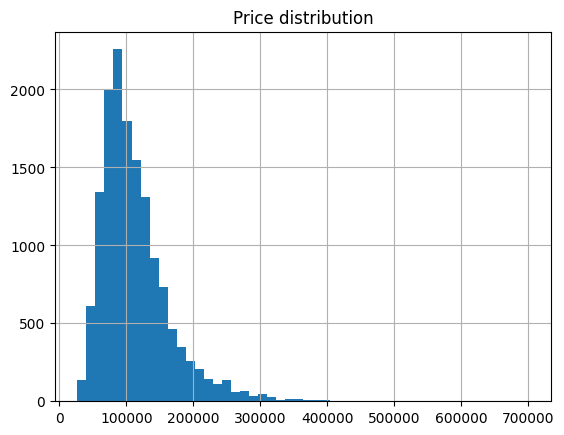

In [491]:
df["price"].hist(bins=50)
plt.title('Price distribution');

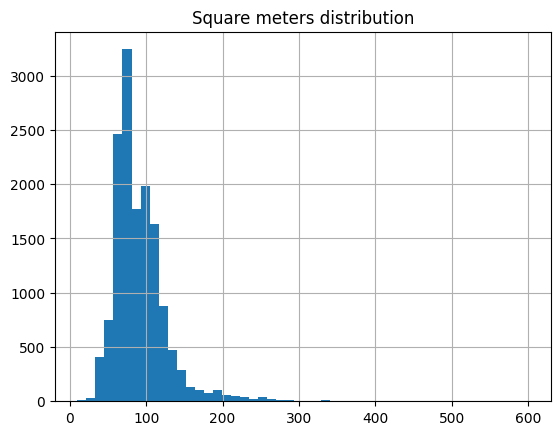

In [492]:
df["square meters"].hist(bins=50)
plt.title('Square meters distribution');

In [493]:
price_zscores = zscore(df["price"])

In [494]:
square_meters_zscores = zscore(df["square meters"])

It's not the best approach to lightly remove data points that are too high however since the dataframe is not rich in features that could possibly explain  high values, we will work only with values within three standard deviation from the mean (zscore < 3) as this would, to some extend, help put the model score better.

If we had features that:
- show the number of bathrooms
- tell whether the apartment is furnished or not
- specify whether there is/are parking spots included
- whether the building has Act 16;
it would have been more reasonable to keep the higher values since the additional features could have served to explain the extremes.

Also, there are a lot of apartments that are either "In construction" or "In a project" but this is not explicitly stated which in and of itself is a major contributor to the price calculation and would distorts the model performance.

In [495]:
# There are no z-scores below 3
df = df[~(price_zscores > 3) & ~(square_meters_zscores > 3)]

## Encoding of categorical columns - `apartment type`, `construction type`, `floor`, `level of completion`, `district`.

In [496]:
def onehot_encoder(df, columns):

  onehot = OneHotEncoder(sparse_output=False, )

  cols_to_encode = columns

  encoded_cols = onehot.fit_transform(df[cols_to_encode])

  df_encoded = pd.DataFrame(encoded_cols, columns = onehot.get_feature_names_out(input_features=cols_to_encode))

  df.reset_index(drop=True, inplace=True)

  new_df = pd.concat([df, df_encoded], axis=1)

  new_df.drop(columns=cols_to_encode, inplace=True)

  return new_df

In [497]:
final_df = onehot_encoder(df, ["district", "construction type", "floor", "level of completion"])

In [498]:
final_df.columns = final_df.columns.str.replace("district_", "").str.replace("construction type_", "").str.replace("floor_", "").str.replace("level of completion_", "")

In [499]:
apartment_type_encode = {'One room apartment': 1,
                         'Studio': 2,
                         'Two-room apartment': 3,
                         'Three-room apartment': 4,
                         'Маisonette': 5,
                         'Multi-room apartment': 6}

In [500]:
final_df["apartment type"].unique()

array(['Two-room apartment', 'Three-room apartment', 'One room apartment',
       'Multi-room apartment', 'Маisonette', 'Studio'], dtype=object)

In [501]:
final_df["apartment type"] = final_df["apartment type"].replace(apartment_type_encode).astype("int")

## Train the model

In [502]:
final_df.shape

(14235, 36)

In [503]:
target = final_df["price"]
features = final_df.drop("price", axis=1)

Hyperparameter tunning with Optuna

In [426]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'reg_lambda': trial.suggest_float('reg_alpha', 0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4,1.0)
    }

    model = xg.XGBRegressor(**params, early_stopping_rounds=50)

    model.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=False)

    preds = model.predict(x_val)
    rmse = MSE(y_val, preds, squared=False)

    return rmse

# Train-test-validation split
x_train, x_temp, y_train, y_temp = train_test_split(features, target, test_size = 0.33, random_state=8)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5, random_state=8)

# Create a study object and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

# Get the best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

Cross validation with Stratified K-Folds

In [427]:
n_splits = 5
skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=8)

rmse_mean = []

for fold,(train_idx, val_idx) in enumerate(skf.split(features, target)):

  print(f"\nFold {fold + 1}/{n_splits}")

  X_train, X_val = features.loc[train_idx], features.loc[val_idx]
  Y_train, Y_val = target[train_idx], target[val_idx]

  best_model = xg.XGBRegressor(**best_params)
  best_model.fit(X_train, Y_train)

  predictions = best_model.predict(X_val)

  # Evaluate the model (you can use different metrics)
  rmse = np.sqrt(MSE(Y_val, predictions))
  rmse_mean.append(rmse)
  print(rmse)
print(f"\nMean RMSE score: {np.mean(rmse_mean)}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Fold 1/5
18856.12808264417

Fold 2/5
19126.522186706756

Fold 3/5
18844.29075829043

Fold 4/5
19389.87673767469

Fold 5/5
18941.875265582345

Mean RMSE score: 19031.73860617968


Check the RMSE on the test data.

In [428]:
new_pred = best_model.predict(x_test)

# RMSE Computation
rmse = np.sqrt(MSE(y_test, new_pred))
print("RMSE : % f" %(rmse))

RMSE :  11828.042682


## Save the model

In [63]:
#model = pickle.load(open('pld_estate_prediction_model.pkl', 'rb'))

In [429]:
pickle.dump(best_model, open('pld_estate_prediction_model.pkl', 'wb'))